---
description: API details.
output-file: machinery_calculation.html
title: module name here

---



In [ ]:
#| default_exp machinery_calculation
%load_ext autoreload
%autoreload 2

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
from typing import List, Union, Type, TypeVar

import MachSysS.gymir_result_pb2 as proto_gymir
from MachSysS.convert_proto_timeseries import convert_proto_timeseries_to_pd_dataframe
import numpy as np
import pandas as pd
from feems.components_model.utility import IntegrationMethod
from feems.system_model import (
    ElectricPowerSystem,
    HybridPropulsionSystem,
    MechanicalPropulsionSystemWithElectricPowerSystem,
    FEEMSResultForMachinerySystem,
)
from feems.types_for_feems import FEEMSResult, TypePower
from feems.simulation_interface import SimulationInterface
from feems.fuel import FuelSpecifiedBy

from RunFeemsSim.pms_basic import (
    PmsLoadTable,
    get_min_load_table_dict_from_feems_system,
    PmsLoadTableSimulationInterface,
)

Numeric = TypeVar("Numeric", int, float, np.ndarray)


def convert_gymir_result_to_propulsion_power_series(
    gymir_result: proto_gymir.GymirResult,
) -> pd.Series:
    time = map(lambda each: each.epoch_s, gymir_result.result)
    power = map(lambda each: each.power_kw, gymir_result.result)
    return pd.Series(index=time, data=power)


class MachineryCalculation:
    def __init__(
        self,
        feems_system: Union[
            ElectricPowerSystem,
            MechanicalPropulsionSystemWithElectricPowerSystem,
            HybridPropulsionSystem,
        ],
        pms: SimulationInterface = None,
        maximum_allowed_power_source_load_percentage: float = 80,
    ):
        self.system_feems = feems_system
        if pms is None:
            load_table = PmsLoadTable(
                min_load2on_pattern=get_min_load_table_dict_from_feems_system(
                    system=feems_system,
                    maximum_allowed_genset_load_percentage=maximum_allowed_power_source_load_percentage,
                )
            )
            self.pms = PmsLoadTableSimulationInterface(
                n_bus_ties=1, pms_load_table=load_table
            )
        else:
            self.pms = pms
        self._set_equal_load_sharing_on_power_sources(n_datapoints=1)

    @property
    def electric_system(self) -> ElectricPowerSystem:
        if self.system_is_not_electric:
            return self.system_feems.electric_system
        else:
            return self.system_feems

    @property
    def system_is_not_electric(self) -> bool:
        return hasattr(self.system_feems, "electric_system")

    def _set_input_load_from_gymir_result(
        self,
        *,
        gymir_result: proto_gymir.GymirResult,
    ) -> None:
        propulsion_power_timeseries = convert_gymir_result_to_propulsion_power_series(
            gymir_result
        )
        self._set_input_load_time_interval_from_propulsion_power_time_series(
            propulsion_power_time_series=propulsion_power_timeseries,
            auxiliary_load_kw=gymir_result.auxiliary_load_kw,
        )

    def _set_input_load_time_interval_from_propulsion_power_time_series(
        self,
        *,
        propulsion_power_time_series: pd.Series,
        auxiliary_load_kw: Numeric,
        time_is_given_as_interval: bool = False,
    ) -> None:
        if time_is_given_as_interval:
            propulsion_power = propulsion_power_time_series.values
            time_interval_s = propulsion_power_time_series.index.to_numpy()
        else:
            propulsion_power = propulsion_power_time_series.values[:-1]
            time_interval_s = np.diff(propulsion_power_time_series.index.to_numpy())

        number_points = len(propulsion_power)
        auxiliary_load_kw = np.atleast_1d(auxiliary_load_kw)
        if len(auxiliary_load_kw) > 1:
            auxiliary_load_kw = auxiliary_load_kw[:number_points]
        else:
            auxiliary_load_kw = np.repeat(auxiliary_load_kw, number_points)
        # set power load
        number_of_propulsors = len(self.electric_system.propulsion_drives)
        if self.system_is_not_electric:
            number_of_propulsors = self.system_feems.mechanical_system.no_mechanical_loads
        number_of_other_loads = len(self.electric_system.other_load)
        if number_of_other_loads == 0:
            assert np.all(
                np.atleast_1d(auxiliary_load_kw) == 0
            ), "Auxiliary load is not zero while other loads are not defined in the system."
        for propulsor in self.electric_system.propulsion_drives:
            propulsor.set_power_input_from_output(
                propulsion_power / number_of_propulsors
            )
        if self.system_is_not_electric:
            for propulsor in self.system_feems.mechanical_system.mechanical_loads:
                propulsor.set_power_input_from_output(
                    propulsion_power / number_of_propulsors
                )
        for other_load in self.electric_system.other_load:
            other_load.power_input = auxiliary_load_kw / number_of_other_loads
        self.electric_system.set_time_interval(
            time_interval_s=time_interval_s,
            integration_method=IntegrationMethod.sum_with_time,
        )
        if self.system_is_not_electric:
            self.system_feems.mechanical_system.set_time_interval(
                time_interval_s=time_interval_s,
                integration_method=IntegrationMethod.sum_with_time,
            )

    def _set_equal_load_sharing_on_power_sources(self, n_datapoints: int) -> None:
        for power_source in self.electric_system.power_sources:
            power_source.load_sharing_mode = np.zeros(shape=[n_datapoints])
        if self.system_is_not_electric:
            for power_source in self.system_feems.mechanical_system.main_engines:
                power_source.load_sharing_mode = np.zeros(shape=[n_datapoints])

    def _set_status_for_mechanical_system(self) -> None:
        """Set the status of main engines for the mechanical system, turning all the gensets on.
        The main engines that are not used for propulsion after the power balance calculation
        will be turned off.
        """
        if np.isscalar(self.system_feems.mechanical_system.time_interval_s):
            n_data_points = 1
        else:
            n_data_points = len(self.system_feems.mechanical_system.time_interval_s)
        for main_engine in self.system_feems.mechanical_system.main_engines:
            main_engine.status = np.ones(n_data_points).astype(bool)

    def _run_simulation(
        self,
        fuel_specified_by: FuelSpecifiedBy = FuelSpecifiedBy.IMO,
        ignore_power_balance: bool = False,
    ) -> Union[FEEMSResult, FEEMSResultForMachinerySystem]:
        """Run the simulation and return the result.

        Args:
            fuel_specified_by(FuelSpecifiedBy): The fuel specified by IMO/EU/USER. Default is IMO.
            ignore_power_balance(bool): If True, the power balance calculation will be ignored.

        Returns:
            The result of the simulation. FEEMSResult or FEEMSResultForMachinery system.
        """
        if ignore_power_balance:
            if self.system_is_not_electric:
                return self.system_feems.get_fuel_energy_consumption_running_time(
                    time_interval_s=self.system_feems.mechanical_system.time_interval_s,
                    integration_method=IntegrationMethod.sum_with_time,
                    fuel_specified_by=fuel_specified_by,
                )
            else:
                return self.system_feems.get_fuel_energy_consumption_running_time(
                    fuel_specified_by=fuel_specified_by
                )

        power_kw_per_switchboard = (
            self.electric_system.get_sum_consumption_kw_sources_switchboard()
        )
        self.pms.set_status(
            power_kw_per_switchboard=power_kw_per_switchboard,
            electric_power_system=self.electric_system,
            time_interval_s=self.electric_system.time_interval_s,
            power_source_priority=None,
        )
        if self.system_is_not_electric:
            self._set_status_for_mechanical_system()
            self.system_feems.do_power_balance_calculation()
            return self.system_feems.get_fuel_energy_consumption_running_time(
                time_interval_s=self.system_feems.mechanical_system.time_interval_s,
                integration_method=IntegrationMethod.sum_with_time,
                fuel_specified_by=fuel_specified_by,
            )
        else:
            self.system_feems.do_power_balance_calculation()
            return self.system_feems.get_fuel_energy_consumption_running_time(
                fuel_specified_by=fuel_specified_by
            )

    def calculate_machinery_system_output_from_gymir_result(
        self,
        *,
        gymir_result: proto_gymir.GymirResult,
        fuel_specified_by: FuelSpecifiedBy = FuelSpecifiedBy.IMO,
        ignore_power_balance: bool = False,
    ) -> Union[FEEMSResult, FEEMSResultForMachinerySystem]:
        """
        Calculate the machinery system output from a Gymir result.

        Args:
            gymir_result(GymirResult): Gymir result given as protobuf message.
            fuel_specified_by(FuelSpecifiedBy): The fuel specified by IMO/EU/USER. Default is IMO.
            ignore_power_balance(bool): If True, the power balance calculation will be ignored.

        Returns:
            The result of the calculation. FEEMSResult or FEEMSResultForMachinerySystem.
        """
        self._set_input_load_from_gymir_result(gymir_result=gymir_result)
        return self._run_simulation(
            fuel_specified_by=fuel_specified_by,
            ignore_power_balance=ignore_power_balance,
        )

    def calculate_machinery_system_output_from_propulsion_power_time_series(
        self,
        *,
        propulsion_power: pd.Series,
        auxiliary_power_kw: Numeric,
        fuel_specified_by: FuelSpecifiedBy = FuelSpecifiedBy.IMO,
        ignore_power_balance: bool = False,
    ) -> Union[FEEMSResult, FEEMSResultForMachinerySystem]:
        """
        Calculate the machinery system output from a time series of the propulsion power and
        auxiliary power.

        Args:
            propulsion_power(pd.Series): The propulsion power time series.
            auxiliary_power_kw(Numeric): The auxiliary power in kW. It can be a single value or
                a numpy array with the same length as the propulsion power.
            fuel_specified_by(FuelSpecifiedBy): The fuel specified by IMO/EU/USER. Default is IMO.
            ignore_power_balance(bool): If True, the power balance calculation will be ignored.

        Returns:
            The result of the calculation. FEEMSResult or FEEMSResultForMachinerySystem.
        """
        if not np.isscalar(auxiliary_power_kw):
            assert (
                len(propulsion_power) == len(auxiliary_power_kw)
                or len(auxiliary_power_kw) == 1
            ), "The length of the auxiliary power must be 1 or the same as the propulsion power"
        self._set_input_load_time_interval_from_propulsion_power_time_series(
            propulsion_power_time_series=propulsion_power,
            auxiliary_load_kw=auxiliary_power_kw,
        )
        return self._run_simulation(
            fuel_specified_by=fuel_specified_by,
            ignore_power_balance=ignore_power_balance,
        )

    def calculate_machinery_system_output_from_time_series_result(
        self,
        *,
        time_series: proto_gymir.TimeSeriesResult,
        fuel_specified_by: FuelSpecifiedBy = FuelSpecifiedBy.IMO,
        ignore_power_balance: bool = False,
    ) -> Union[FEEMSResult, FEEMSResultForMachinerySystem]:
        """
        Calculate the machinery system output from statistics of the propulsion power.
        Args:
            time_series(TimeSeriesResult): Time series result given as protobuf message.
            fuel_specified_by(FuelSpecifiedBy): The fuel specified by IMO/EU/USER. Default is IMO.
            ignore_power_balance(bool): If True, the power balance calculation will be ignored.

        Returns:
            The result of the simulation. FEEMSResult or FEEMSResultForMachinery system.
        """
        df = convert_proto_timeseries_to_pd_dataframe(time_series)
        self._set_input_load_time_interval_from_propulsion_power_time_series(
            propulsion_power_time_series=df["propulsion_power_kw"],
            auxiliary_load_kw=df["auxiliary_power_kw"].values
        )
        return self._run_simulation(
            fuel_specified_by=fuel_specified_by,
            ignore_power_balance=ignore_power_balance,
        )

    def calculate_machinery_system_output_from_statistics(
        self,
        *,
        propulsion_power: np.ndarray,
        frequency: np.ndarray,
        auxiliary_power_kw: Numeric,
        fuel_specified_by: FuelSpecifiedBy = FuelSpecifiedBy.IMO,
        ignore_power_balance: bool = False,
    ) -> Union[FEEMSResult, FEEMSResultForMachinerySystem]:
        """
        Calculate the machinery system output from statistics of the propulsion power.

        Args:
            propulsion_power(np.ndarray): The propulsion power for each mode in kW.
            frequency(np.ndarray): The frequency of each mode in seconds. If the frequency is
                given as normalized value, the output should be interpreted as per second value.
            auxiliary_power_kw(Numeric): The auxiliary power for each mode in kW. It is also
                possible to give a single value for all modes.
            fuel_specified_by(FuelSpecifiedBy): The fuel specified by IMO/EU/USER. Default is IMO.
            ignore_power_balance(bool): If True, the power balance calculation will be ignored.

        Returns:
            The result of the simulation. FEEMSResult or FEEMSResultForMachinery system.
        """
        if not np.isscalar(auxiliary_power_kw):
            assert (
                len(propulsion_power) == len(auxiliary_power_kw)
                or len(auxiliary_power_kw) == 1
            ), "The length of the auxiliary power must be 1 or the same as the propulsion power"
        self._set_input_load_time_interval_from_propulsion_power_time_series(
            propulsion_power_time_series=pd.Series(
                data=propulsion_power, index=frequency
            ),
            auxiliary_load_kw=auxiliary_power_kw,
            time_is_given_as_interval=True,
        )
        return self._run_simulation(
            fuel_specified_by=fuel_specified_by,
            ignore_power_balance=ignore_power_balance,
        )

In [ ]:
import json
import os
import random
import pandas as pd
import numpy as np
from MachSysS.gymir_result_pb2 import GymirResult, SimulationInstance, TimeSeriesResult
from MachSysS.convert_to_feems import convert_proto_propulsion_system_to_feems
from MachSysS.utility import retrieve_machinery_system_from_file
from MachSysS.convert_feems_result_to_proto import FEEMSResultConverter
from RunFeemsSim.machinery_calculation import MachineryCalculation, convert_gymir_result_to_propulsion_power_series

2023-11-22 09:55:46,545 - feems.components_model.utility - ERROR - The data is not compatible with the given time step.
2023-11-22 09:55:46,545 - feems.components_model.node - WARNING - Integration occurred for other loadThe data is not compatible with the given time step.


name: "Electric propulsion system"
propulsion_type: ELECTRIC
maximum_allowed_genset_load_percentage: 80
electric_system {
  switchboards {
    switchboard_id: 1
    subsystems {
      engine {
        rated_power_kw: 1000
        rated_speed_rpm: 1000
        bsfc {
          curve {
            x_label: "power load"
            y_label: "bsfc"
            curve {
              points {
                x: 0.1
                y: 270
              }
              points {
                x: 0.25
                y: 240
              }
              points {
                x: 0.5
                y: 220
              }
              points {
                x: 0.75
                y: 210
              }
              points {
                x: 1
                y: 220
              }
            }
          }
        }
        main_fuel {
          fuel_origin: FOSSIL
        }
        order_from_switchboard_or_shaftline: 2
        nox_calculation_method: TIER_3
      }
      electric_mac

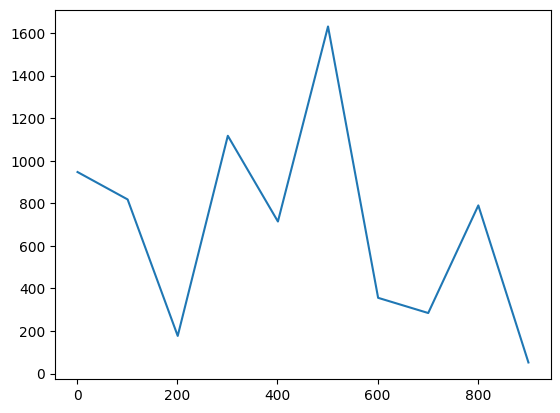

In [ ]:
def create_gymir_result() -> GymirResult:
    return GymirResult(
        name="test",
        auxiliary_load_kw = random.random() * 500,
        result=[
            SimulationInstance(epoch_s=100 * index + 1, power_kw=2000 * random.random())
            for index, _ in enumerate(range(10))
        ],
    )

# Testing convert gymir result to propulsion power series
gymir_result = create_gymir_result()
propulsion_power = convert_gymir_result_to_propulsion_power_series(gymir_result)
assert len(gymir_result.result) == len(propulsion_power)
propulsion_power.plot()

# Testing MachineryCalculation
save_the_result = False
path = os.path.join("tests", "system_proto.mss")
system_proto = retrieve_machinery_system_from_file(path)
print(system_proto)
system_feems = convert_proto_propulsion_system_to_feems(system_proto)
machinery_calculation = MachineryCalculation(feems_system=system_feems)
res = machinery_calculation.calculate_machinery_system_output_from_gymir_result(
    gymir_result=gymir_result
)
if save_the_result:
    with open("system_proto.mss", 'wb') as file:
        file.write(system_proto.SerializeToString())
average_power_consumption = 0
running_hours_mean = 0
for power_source in machinery_calculation.electric_system.power_sources:
    running_hours_mean += (power_source.power_output > 0).mean()
    generator_run_point = \
        power_source.get_fuel_cons_load_bsfc_from_power_out_generator_kw()
for propulsor in machinery_calculation.electric_system.propulsion_drives:
    average_power_consumption += propulsor.power_input.mean()
average_bsfc_for_engines = res.fuel_consumption_total_kg / \
                           (res.duration_s / 3600000 * average_power_consumption / 0.95)
print(f"Average bsfc for engines: {average_bsfc_for_engines} g/kWh")
assert 200 < average_bsfc_for_engines < 385

In [ ]:
# Testing MachineryCalculation with time series
auxiliary_power_kw = 100
res_scalar_aux = machinery_calculation.calculate_machinery_system_output_from_propulsion_power_time_series(
    propulsion_power=propulsion_power,
    auxiliary_power_kw=auxiliary_power_kw
)
print(len(propulsion_power))
auxiliary_power_kw = np.ones(len(propulsion_power)) * 100
res_array_aux = machinery_calculation.calculate_machinery_system_output_from_propulsion_power_time_series(
    propulsion_power=propulsion_power,
    auxiliary_power_kw=auxiliary_power_kw
)

2023-11-22 09:55:46,623 - feems.components_model.utility - ERROR - The data is not compatible with the given time step.
2023-11-22 09:55:46,624 - feems.components_model.node - WARNING - Integration occurred for other loadThe data is not compatible with the given time step.
2023-11-22 09:55:46,629 - feems.components_model.utility - ERROR - The data is not compatible with the given time step.
2023-11-22 09:55:46,629 - feems.components_model.node - WARNING - Integration occurred for other loadThe data is not compatible with the given time step.


10


In [ ]:
# Testing MachineryCalculation with time series result (protobuf)
path_to_system = os.path.join("tests", "mechanical_propulsion_with_electric_system.mss")
system_proto = retrieve_machinery_system_from_file(path_to_system)
system_feems = convert_proto_propulsion_system_to_feems(system_proto)

path_to_result = os.path.join("tests", "time_series_result.pb")
with open(path_to_result, "rb") as file:
    time_series_result = TimeSeriesResult()
    time_series_result.ParseFromString(file.read())

machinery_calculation = MachineryCalculation(feems_system=system_feems)
res = machinery_calculation.calculate_machinery_system_output_from_time_series_result(
    time_series=time_series_result
)

2023-11-22 09:55:46,814 - feems.components_model.utility - ERROR - The data is not compatible with the given time step.
2023-11-22 09:55:46,814 - feems.components_model.node - WARNING - Integration occurred for other loadThe data is not compatible with the given time step.


In [ ]:
total_energy_consumption_kwh = np.array([
    [prop_power_inst.propulsion_power_kw, prop_power_inst.auxiliary_power_kw]
    for prop_power_inst in time_series_result.propulsion_power_timeseries
]) * 60 / 3600
total_propulsion_energy_consumption_kwh = np.sum(total_energy_consumption_kwh[:, 0])
total_auxiliary_energy_consumption_kwh = np.sum(total_energy_consumption_kwh[:, 1])
average_bsfc_for_main_engine = res.mechanical_system.multi_fuel_consumption_total_kg.natural_gas / total_propulsion_energy_consumption_kwh * 1000
average_pilot_bsfc_for_main_engine = res.mechanical_system.multi_fuel_consumption_total_kg.diesel / total_propulsion_energy_consumption_kwh * 1000
average_bsfc_for_auxiliary_engines = res.electric_system.multi_fuel_consumption_total_kg.natural_gas / total_auxiliary_energy_consumption_kwh * 1000 * 0.95
print(f"Average bsfc for main engine: {average_bsfc_for_main_engine} g/kWh")
print(f"Average bsfc for pilot fuel for main engine: {average_pilot_bsfc_for_main_engine} g/kWh")
print(f"Average bsfc for auxiliary engines: {average_bsfc_for_auxiliary_engines} g/kWh")
assert 150 > average_bsfc_for_main_engine > 140, "Average bsfc for main engine is not within expected range"
assert 1.0 > average_pilot_bsfc_for_main_engine > 0.7, "Average pilot bsfc for main engine is not within expected range"
assert 224 > average_bsfc_for_auxiliary_engines > 210, "Average bsfc for auxiliary engines is not within expected range"

Average bsfc for main engine: 142.94064926651433 g/kWh
Average bsfc for pilot fuel for main engine: 0.8867935846667633 g/kWh
Average bsfc for auxiliary engines: 213.1961969407553 g/kWh
